**<center><h1>Data Extraction</h1></center>**

In [ ]:
SELECT 
    purchase_id, 
    student_id, 
    plan_id, 
    date_purchased AS date_start, 
    CASE
        WHEN plan_id = 0 THEN DATE_ADD(date_purchased, INTERVAL 1 MONTH)
        WHEN plan_id = 1 THEN DATE_ADD(date_purchased, INTERVAL 3 MONTH) 
        WHEN plan_id = 2 THEN DATE_ADD(date_purchased, INTERVAL 1 YEAR)  
        ELSE NULL
    END AS date_end,
    date_refunded
FROM 
    student_purchases;

In [ ]:
SELECT 
    purchase_id,
    student_id,
    plan_id,
    date_start,
    IF (date_refunded IS NULL, date_end, date_refunded) AS date_end
FROM
    (SELECT 
        purchase_id, 
        student_id, 
        plan_id, 
        date_purchased AS date_start, 
        CASE
            WHEN plan_id = 0 THEN DATE_ADD(date_purchased, INTERVAL 1 MONTH)
            WHEN plan_id = 1 THEN DATE_ADD(date_purchased, INTERVAL 3 MONTH) 
            WHEN plan_id = 2 THEN DATE_ADD(date_purchased, INTERVAL 1 YEAR)  
            ELSE NULL
        END AS date_end,
        date_refunded
    FROM 
        student_purchases
    ) AS sub_a;

In [ ]:
CREATE OR REPLACE VIEW purchases_info AS
SELECT
	purchase_id,
    student_id,
    plan_id,
    date_start,
    date_end,
    CASE
		WHEN date_start >= '2021-07-01' THEN 0
        WHEN date_end <= '2021-03-31' THEN 0
        ELSE 1 
	END AS 'paid_q2_2021',
	CASE
		WHEN date_start >= '2022-07-01' THEN 0
        WHEN date_end <= '2022-03-31' THEN 0
        ELSE 1 
	END AS 'paid_q2_2022'
FROM
	(SELECT
		purchase_id,
		student_id,
		plan_id,
		date_start,
		IF(date_refunded IS NULL, date_end_initial, date_refunded) AS `date_end`
	FROM
		(SELECT 
			purchase_id, 
			student_id, 
			plan_id, 
			date_purchased AS `date_start`, 
			CASE 
				WHEN plan_id = 0 THEN DATE_ADD(date_purchased, INTERVAL 1 MONTH)
				WHEN plan_id = 1 THEN DATE_ADD(date_purchased, INTERVAL 3 MONTH)
				WHEN plan_id = 2 THEN DATE_ADD(date_purchased, INTERVAL 1 YEAR)
				WHEN plan_id = 3 THEN NULL
			END AS `date_end_initial`,
			date_refunded
		FROM 
            student_purchases
		)sub_a
	)sub_b; 

**SECTION FOUR**

In [ ]:
-- Total minutes watched in Q2 2021
SELECT 
    student_id, 
    ROUND(SUM(seconds_watched/60),2) AS minutes_watched
FROM 
    student_video_watched
WHERE date_watched BETWEEN '2021-04-01' AND '2021-06-30'
GROUP BY student_id;

-- Total minutes watched in Q2 2022
SELECT 
    student_id, 
    ROUND(SUM(seconds_watched/60),2) AS minutes_watched
FROM 
    student_video_watched
WHERE date_watched BETWEEN '2022-04-01' AND '2022-06-30'
GROUP BY student_id;


**SECTION FIVE**

In [ ]:
-- Students engaged in Q2 2021 who haven’t had a paid subscription in Q2 2021

CREATE OR REPLACE VIEW minutes_watched_2021_paid_0 AS
SELECT 
    mw.student_id,
    mw.minutes_watched,
    MAX(IF(paid_q2_2021 = 1, 1, 0)) AS paid_in_q2
FROM 
    (SELECT 
        student_id,
        TRUNCATE(SUM(seconds_watched / 60), 2) AS minutes_watched
    FROM 
        student_video_watched
    WHERE date_watched BETWEEN '2021-04-01' AND '2021-06-30'
    GROUP BY student_id) AS mw
LEFT JOIN 
    purchases_info pi ON mw.student_id = pi.student_id
GROUP BY 
	mw.student_id,
    mw.minutes_watched
HAVING 
    paid_in_q2 = 0;

In [ ]:
-- Students engaged in Q2 2022 who haven’t had a paid subscription in Q2 2022

CREATE OR REPLACE VIEW minutes_watched_2022_paid_0 AS    
SELECT 
    mw.student_id,
    mw.minutes_watched,
    MAX(IF(paid_q2_2022 = 1, 1, 0)) AS paid_in_q2
FROM 
    (SELECT 
        student_id,
        TRUNCATE(SUM(seconds_watched / 60), 2) AS minutes_watched
    FROM student_video_watched
    WHERE date_watched BETWEEN '2022-04-01' AND '2022-06-30'
    GROUP BY student_id) AS mw
LEFT JOIN 
    purchases_info pi ON mw.student_id = pi.student_id
GROUP BY 
	mw.student_id,
    mw.minutes_watched
HAVING 
    paid_in_q2 = 0;

In [ ]:
-- Students engaged in Q2 2021 who have been paid subscribers in Q2 2021 

CREATE OR REPLACE VIEW minutes_watched_2021_paid_1 AS    
SELECT 
    mw.student_id,
    mw.minutes_watched,
    MAX(IF(paid_q2_2021 = 1, 1, 0)) AS paid_in_q2
FROM 
    (SELECT 
        student_id,
        TRUNCATE(SUM(seconds_watched / 60), 2) AS minutes_watched
    FROM student_video_watched
    WHERE date_watched BETWEEN '2021-04-01' AND '2021-06-30'
    GROUP BY student_id) AS mw
LEFT JOIN 
    purchases_info pi ON mw.student_id = pi.student_id
GROUP BY 
	mw.student_id,
    mw.minutes_watched
HAVING 
    paid_in_q2 = 1;

In [ ]:
-- Students engaged in Q2 2022 who have been paid subscribers in Q2 2021 

CREATE OR REPLACE VIEW minutes_watched_2022_paid_1 AS
SELECT 
    mw.student_id,
    mw.minutes_watched,
    MAX(IF(paid_q2_2022 = 1, 1, 0)) AS paid_in_q2
FROM 
    (SELECT 
        student_id,
        TRUNCATE(SUM(seconds_watched / 60), 2) AS minutes_watched
    FROM student_video_watched
    WHERE date_watched BETWEEN '2022-04-01' AND '2022-06-30'
    GROUP BY student_id) AS mw
LEFT JOIN 
    purchases_info pi ON mw.student_id = pi.student_id
GROUP BY 
	mw.student_id,
    mw.minutes_watched
HAVING 
    paid_in_q2 = 1;

**SECTION SIX**

In [ ]:
SELECT 
	cc.student_id, 
    cc.certificates_issued, 
    SUM(IF(seconds_watched IS NULL, 0, TRUNCATE(sw.seconds_watched/60,2))) AS minutes_watched
FROM 
    (SELECT student_id, COUNT(certificate_id) AS certificates_issued
	FROM student_certificates
	GROUP BY 1) cc
LEFT JOIN
	student_video_watched AS sw ON cc.student_id = sw.student_id
GROUP BY 1,2;

**<center><h1>Data Preprocessing</h1></center>**

**SECTION ONE**

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# import Q2 2021 data
minutes_watched_2021_paid_0 = pd.read_csv('minutes_watched_2021_paid_0.csv')
minutes_watched_2021_paid_1 = pd.read_csv('minutes_watched_2021_paid_1.csv')

# import Q2 2022 data
minutes_watched_2022_paid_0 = pd.read_csv('minutes_watched_2022_paid_0.csv')
minutes_watched_2022_paid_1 = pd.read_csv('minutes_watched_2022_paid_1.csv')


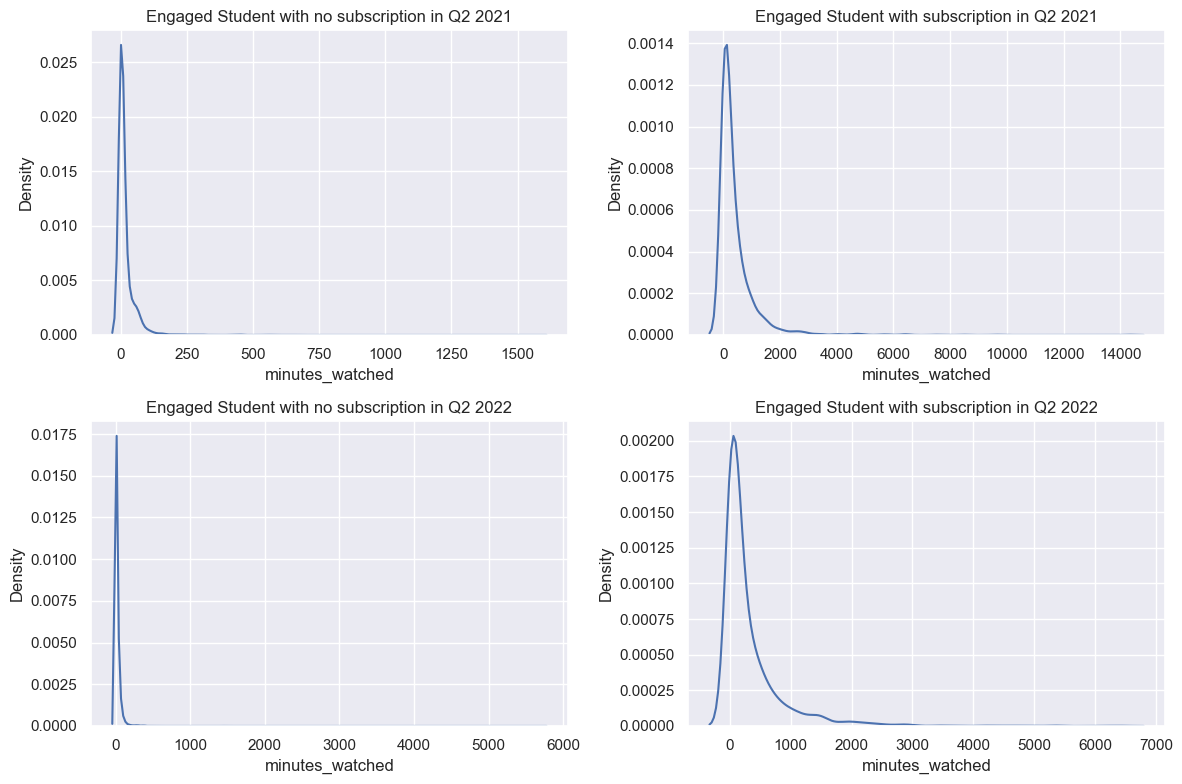

In [11]:
#initial kde plot

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot KDE for each dataset on a different subplot
sns.kdeplot(minutes_watched_2021_paid_0['minutes_watched'], ax=axes[0, 0])
axes[0, 0].set_title('Engaged Student with no subscription in Q2 2021')

sns.kdeplot(minutes_watched_2021_paid_1['minutes_watched'], ax=axes[0, 1])
axes[0, 1].set_title('Engaged Student with subscription in Q2 2021')

sns.kdeplot(minutes_watched_2022_paid_0['minutes_watched'], ax=axes[1, 0])
axes[1, 0].set_title('Engaged Student with no subscription in Q2 2022')

sns.kdeplot(minutes_watched_2022_paid_1['minutes_watched'], ax=axes[1, 1])
axes[1, 1].set_title('Engaged Student with subscription in Q2 2022')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

In [4]:
# remove outliers

Q2021_paid0_99p = minutes_watched_2021_paid_0['minutes_watched'].quantile(q=0.99)
minutes_watched_2021_paid_0_no_outliers = minutes_watched_2021_paid_0[minutes_watched_2021_paid_0['minutes_watched'] < Q2021_paid0_99p]

Q2022_paid0_99p = minutes_watched_2022_paid_0['minutes_watched'].quantile(q=0.99)
minutes_watched_2022_paid_0_no_outliers = minutes_watched_2022_paid_0[minutes_watched_2022_paid_0['minutes_watched'] < Q2022_paid0_99p]

Q2021_paid1_99p = minutes_watched_2021_paid_1['minutes_watched'].quantile(q=0.99)
minutes_watched_2021_paid_1_no_outliers = minutes_watched_2021_paid_1[minutes_watched_2021_paid_1['minutes_watched'] < Q2021_paid1_99p]

Q2022_paid1_99p = minutes_watched_2022_paid_1['minutes_watched'].quantile(q=0.99)
minutes_watched_2022_paid_1_no_outliers = minutes_watched_2022_paid_1[minutes_watched_2022_paid_1['minutes_watched'] < Q2022_paid1_99p]

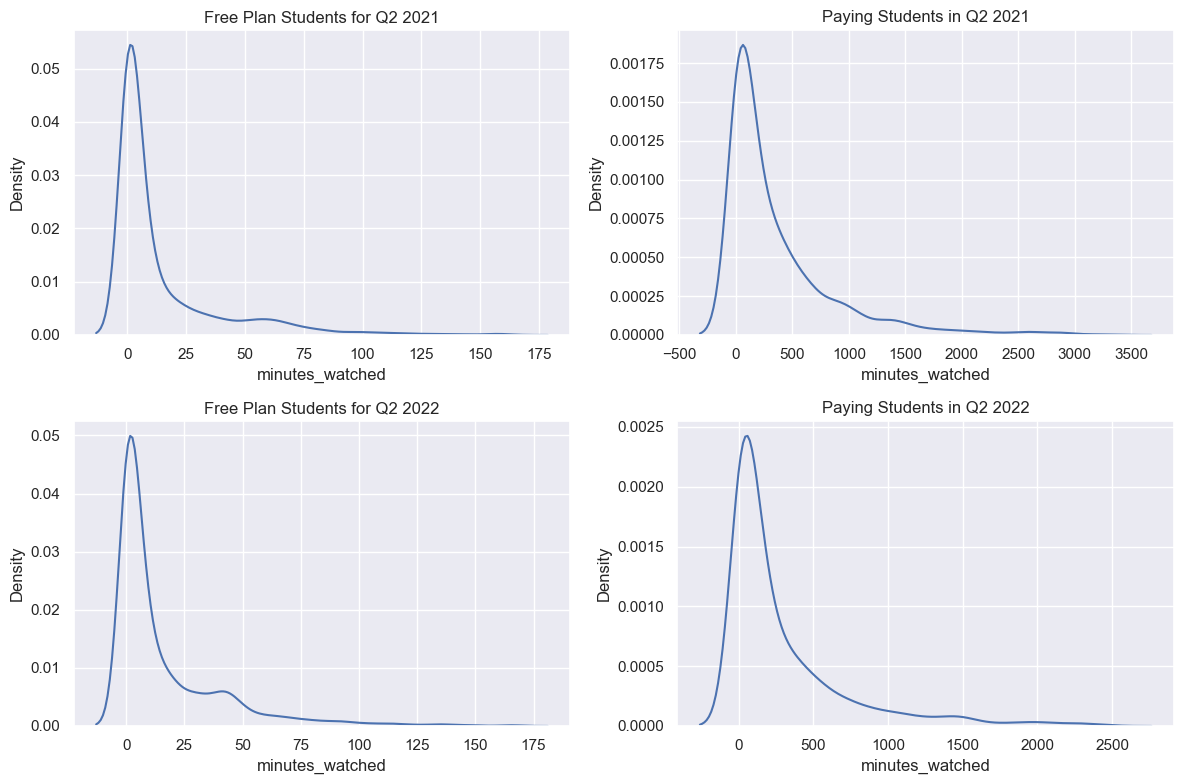

In [6]:
# kde plot after removing outliers

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot KDE for each dataset on a different subplot
sns.kdeplot(minutes_watched_2021_paid_0_no_outliers['minutes_watched'], ax=axes[0, 0])
axes[0, 0].set_title('Free Plan Students for Q2 2021')

sns.kdeplot(minutes_watched_2021_paid_1_no_outliers['minutes_watched'], ax=axes[0, 1])
axes[0, 1].set_title('Paying Students in Q2 2021')

sns.kdeplot(minutes_watched_2022_paid_0_no_outliers['minutes_watched'], ax=axes[1, 0])
axes[1, 0].set_title('Free Plan Students for Q2 2022')

sns.kdeplot(minutes_watched_2022_paid_1_no_outliers['minutes_watched'], ax=axes[1, 1])
axes[1, 1].set_title('Paying Students in Q2 2022')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# export processed data

# Q2 2021
minutes_watched_2021_paid_0_no_outliers.to_csv('minutes_watched_2021_paid_0_no_outliers.csv', index=False)
minutes_watched_2021_paid_1_no_outliers.to_csv('minutes_watched_2021_paid_1_no_outliers.csv', index=False)

# Q2 2022'
minutes_watched_2022_paid_0_no_outliers.to_csv('minutes_watched_2022_paid_0_no_outliers.csv', index=False)
minutes_watched_2022_paid_1_no_outliers.to_csv('minutes_watched_2022_paid_1_no_outliers.csv', index=False)

**<center><h1>Probabilities and Dependacies</h1></center>**

In [ ]:
-- All students who’ve watched a lecture on the platform = 15840
SELECT COUNT(DISTINCT student_id)
FROM student_video_watched;

-- All students who’ve watched a lecture on the platform in 2021 = 7639
SELECT COUNT(DISTINCT student_id)
FROM student_video_watched
WHERE date_watched BETWEEN '2021-01-01' AND '2021-12-31';

-- All students who’ve watched a lecture on the platform in 2022 = 8841
SELECT COUNT(DISTINCT student_id)
FROM student_video_watched
WHERE date_watched BETWEEN '2022-01-01' AND '2022-12-31';

-- All students who watched in both Q2 2021 and Q2 2022 = 640
SELECT COUNT(DISTINCT x.student_id) AS student_id
FROM
    (SELECT DISTINCT student_id AS student_id
    FROM student_video_watched
    WHERE date_watched BETWEEN '2021-01-01' AND '2021-12-31') x
INNER JOIN
    (SELECT DISTINCT student_id AS student_id
    FROM student_video_watched
    WHERE date_watched BETWEEN '2022-01-01' AND '2022-12-31') y 
ON x.student_id = y.student_id

In [ ]:
-- P(A) = The probability that a student watched a lecture in Q2 2021 = 0.4823

WITH
    prA AS
    (SELECT COUNT(DISTINCT student_id) AS id_count
    FROM student_video_watched
    WHERE date_watched BETWEEN '2021-01-01' AND '2021-12-31'),

    Us AS
    (SELECT COUNT(DISTINCT student_id) AS id_count
    FROM student_video_watched)

SELECT prA.id_count/Us.id_count AS P_A
FROM prA, Us;


-- P(B) = The probability that a student watched a lecture in Q2 2022 = 0.5581

WITH
    prB AS
    (SELECT COUNT(DISTINCT student_id) AS id_count
    FROM student_video_watched
    WHERE date_watched BETWEEN '2022-01-01' AND '2022-12-31'),

    Us AS
    (SELECT COUNT(DISTINCT student_id) AS id_count
    FROM student_video_watched)

SELECT prB.id_count/Us.id_count AS P_B
FROM prB, Us;


-- P(B∩A) = Probability of students who watched in both Q2 2021 and Q2 2022 = 0.0404

WITH
    prBA AS
    (SELECT COUNT(x.student_id) AS student_id
    FROM
        (SELECT DISTINCT student_id AS student_id
        FROM student_video_watched
        WHERE date_watched BETWEEN '2021-01-01' AND '2021-12-31') x
    INNER JOIN
        (SELECT DISTINCT student_id AS student_id
        FROM student_video_watched
        WHERE date_watched BETWEEN '2022-01-01' AND '2022-12-31') y ON x.student_id = y.student_id),

    Us AS
    (SELECT COUNT(DISTINCT student_id) AS id_count
    FROM student_video_watched)

SELECT prBA.student_id/Us.id_count AS P_BnA
FROM prBA, Us

$$P(A) = 0.4823,\;  P(B) = 0.5581,\;  P(B \cap A) = 0.0404$$

1. Determine if watching a lecture in Q2 2021 and Q2 2022 are dependent or independent events:

$$P(B|A) = \frac{P(B \cap A)}{P(A)} = \frac{0.0404}{0.4823} = 0.0838$$

$$ P(B|A) \neq P(B).\; \text{Hence, watching a lecture in Q2 2021 and Q2 2022 are dependent events} $$


2. What is the probability that a student has watched a lecture in Q2 2021, given that they’ve watched a lecture in Q2 2022:

$$P(A|B) = \frac{P(A \cap B)}{P(B)} = \frac{0.0404}{0.5581} = 0.0724$$

**<center><h1>Machine Learning Modeling And Deployment</h1></center>**

In [7]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression

In [ ]:
data = pd.read_csv('minutes_and_certificates.csv')
task_dataset = data.copy()
task_dataset.describe()
task_dataset.head()

# check for null values
print(task_dataset.isnull().any(), end='\n\n')

# visualize the attributes of my data
#sns.displot(data=task_dataset, x='certificates_issued', kind='kde')

# split into input and target values
X = task_dataset['minutes_watched'].values.reshape(-1,1)
y = task_dataset['certificates_issued']

# splittig the dataset into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=365)

# train model
reg = LinearRegression()
reg.fit(X_train, y_train)


# parameters
print('rsquared =',reg.score(X_train, y_train))
print('slope =', reg.coef_)
print('intercept =', reg.intercept_)


# test the model
y_pred = reg.predict(X_test).astype(int)
y_pred

# test model with new data - minutes_watched = 1200
new_data = pd.DataFrame({'minutes_watched':[1200]})
new_data = new_data['minutes_watched'].values.reshape(-1,1) #preparing data for model

reg.predict(new_data).astype(int)

<center>Linear equation that explains the behaviour of the relationship</center>

$$ y = 0.00174x +  1.0565 $$

<center>R-squared value of the regression</center>

$$R^2 = 0.3053$$